In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

This image is a <class 'numpy.ndarray'> with dimensions (300, 300)
This image is a <class 'numpy.ndarray'> with dimensions (512, 512, 3)


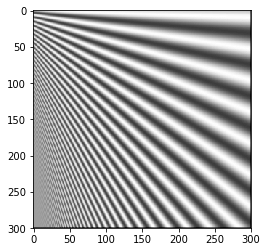

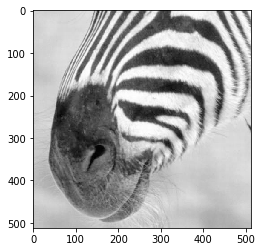

In [97]:
# Load two toy images

stripes = plt.imread("pn1.jpg")
print(f"This image is a {type(stripes)} with dimensions {stripes.shape}")
plt.figure()
plt.imshow(stripes, cmap="gray")

zebra = plt.imread("zebra.png")
print(f"This image is a {type(zebra)} with dimensions {zebra.shape}")
# extract one band from RGB
zebra = zebra[:,:,1]
plt.figure()
plt.imshow(zebra, cmap="gray")

To create a Gaussian kernel in 1D we need the formula
$$G(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-x^2/2\sigma^2}$$

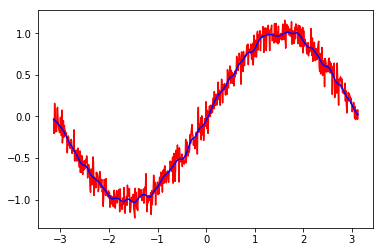

In [69]:
# Create a function that returns a 1D gaussian kernel
def gaussian(sigma: float) -> np.ndarray:
    # if we go from -3sigma to 3sigma we will get almost all the mass of the gaussian
    bnd = math.ceil(3*sigma)
    xs = np.arange(-bnd, bnd+1)
    ker = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-np.power(xs,2)/(2*sigma**2))
    return ker/np.sum(ker)

# use it to smooth a sine function that was affected with some noise
xs = np.arange(-3.14, 3.14, 0.01)
sin = np.sin(xs)
noisy = sin + np.random.normal(0, 0.1, sin.shape)
clean = np.convolve(noisy, gaussian(5), 'same')

plt.figure()
plt.plot(xs, noisy, "r")
plt.plot(xs, clean, "b")

In [90]:
# Now we use that to convolve an image with a gaussian kernel
def gaussConvolve(img: np.ndarray, sigma:float) -> np.ndarray:
    kernel1D = np.expand_dims(gaussian(sigma), 0) # make this a 1xN matrix
    kernel2D = np.dot(kernel1D.T, kernel1D)
    return signal.convolve2d(img, kernel2D, "same")

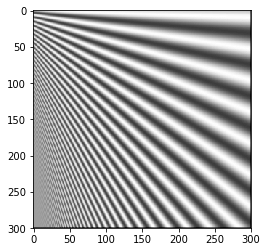

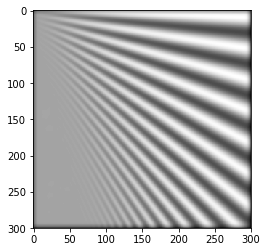

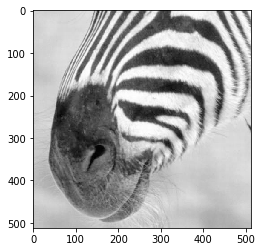

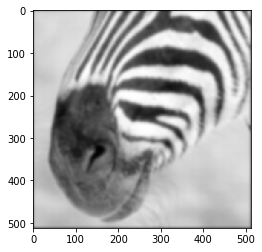

In [101]:
plt.figure()
plt.imshow(stripes, cmap="gray")
plt.figure()
plt.imshow(gaussConvolve(stripes, 3), cmap="gray")
plt.figure()
plt.imshow(zebra, cmap="gray")
plt.figure()
plt.imshow(gaussConvolve(zebra, 3), cmap="gray")

Now we can extract edges by finding the gradient of the image, $\nabla I$.

The convolution has a nice property, hence finding the gradient of the convolved image will be the same as convolving with the derivative of the kernel,

$$\nabla (I * G) = I*(\nabla G)$$

so we just need to know that

$$\frac{d}{dx}G(x) = -\frac{x}{\sigma^2}G(x)$$

In [115]:
# create a function that computes gradient magnitude and orientation for a given image
def imagegrad(img: np.ndarray, sigma:float) -> list:
    # start by creating the kernel of the derivative
    bnd = math.ceil(3*sigma)
    xs = np.arange(-bnd, bnd+1)
    ker = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-np.power(xs,2)/(2*sigma**2))
    # normalize
    ker = ker/np.sum(ker)
    dker = -xs/sigma**2*ker
    # create kernels for dx and dy
    l = len(dker)
    xker = np.zeros([l, l])
    xker[math.ceil(l/2), :] = dker
    yker = xker.T
    
    dx = signal.convolve2d(img, xker, "same")
    dy = signal.convolve2d(img, yker, "same")
    return np.sqrt(np.power(dx,2)+np.power(dy,2)), np.arctan2(dy, dx)

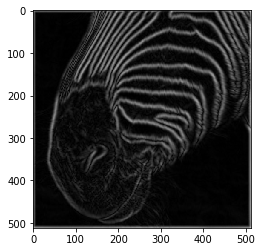

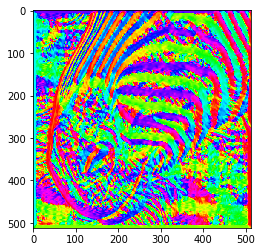

In [119]:
mag, orient = imagegrad(zebra, 3)
plt.figure()
plt.imshow(mag, cmap="gray")
plt.figure()
plt.imshow(orient/math.pi, cmap="hsv")

Finally we will also consider the second derivative of the Gaussian filter, because sometimes we also care about taking the $2nd$ derivative of an image. For example, edges can be found where $\Delta (I * G) = I*\Delta G$ changes signs.

Just bear in mind that
$$\frac{d^2}{dx^2}G(x) = \frac{-\sigma^2 + x^2}{\sigma^4}G(x)$$

In [123]:
# Create a function that find any of several derivatives of an image
def imageDerivatives(img: np.ndarray, sigma:float, typ:str) -> np.ndarray:
    # typ can be any of 'x', 'y', 'xx', 'yy', 'xy', 'yx'
    # start by creating the relevant kernels
    bnd = math.ceil(3*sigma)
    xs = np.arange(-bnd, bnd+1)
    ker = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-np.power(xs,2)/(2*sigma**2))
    # normalize
    ker = ker/np.sum(ker)
    dker = -xs/sigma**2*ker
    ddker = ((-sigma**2 + np.power(xs, 2))/sigma**4)*ker
    # create the dx kernel in 2D
    l = len(dker)
    xker = np.zeros([l, l])
    xker[math.ceil(l/2), :] = dker
    # create the ddxx kernel in 2D
    xxker = np.zeros([l, l])
    xxker[math.ceil(l/2), :] = ddker
    if len(typ) == 1:
        if typ == "x":
            return signal.convolve2d(img, xker, "same")
        elif typ == "y":
            return signal.convolve2d(img, xker.T, "same")
    elif len(typ) == 2:
        if typ[0] != typ[1]:
            return imageDerivatives(imageDerivatives(img, sigma, typ[1]), sigma, typ[0])
        elif typ == "xx":
            return signal.convolve2d(img, xxker, "same")
        elif typ == "yy":
            return signal.convolve2d(img, xxker.T, "same")

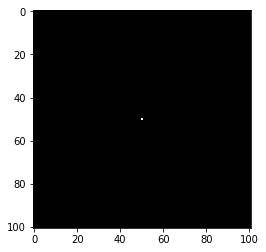

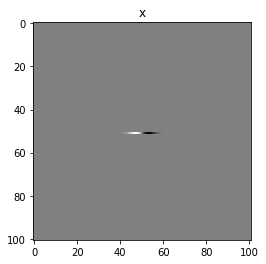

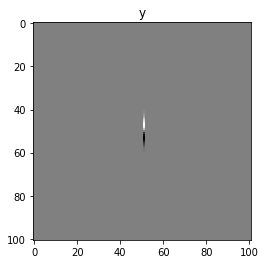

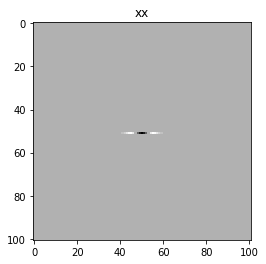

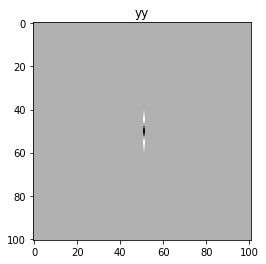

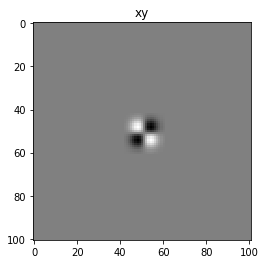

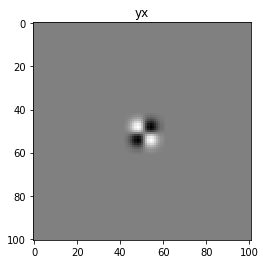

In [127]:
# create an impulse signal
N = 50
impulse = np.zeros([2*N+1, 2*N+1])
impulse[N, N] = 255
plt.figure()
plt.imshow(impulse, cmap="gray")

# convolve with all the available derivatives we have
ds = ["x", "y", "xx", "yy", "xy", "yx"] # xy and yx give the same result
sigma = 3
for d in ds:
    plt.figure()
    plt.imshow(imageDerivatives(impulse, sigma, d), cmap="gray")
    plt.title(d)

Find the edges of the zebra image with the magnitude of the gradient and with the zero crossings of the Laplacian,

$$\Delta I = \frac{d^2I}{dx^2} + \frac{d^2I}{dy^2}$$

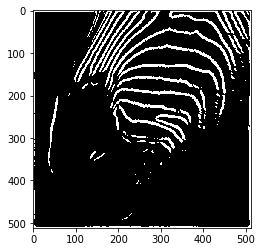

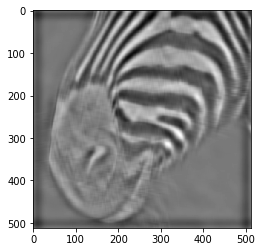

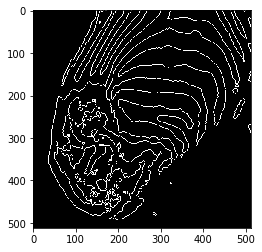

In [141]:
mag, orient = imagegrad(zebra, 3)
mag = mag/np.max(mag) # normalize it
edges_grad = np.zeros(mag.shape)
edges_grad[mag > 0.3] = 255 # the decimal there is just a thresholding value
plt.figure()
plt.imshow(edges_grad, cmap="gray")

ddxx = imageDerivatives(zebra, 11, "xx")
ddyy = imageDerivatives(zebra, 11, "yy")
laplacian = ddxx + ddyy
# plot the laplacian
plt.figure()
plt.imshow(laplacian, cmap="gray")
edges_laplace = np.zeros(laplacian.shape)
# a pixel ij may be a zero crossing if (i-1,j)*(i+1,j) < 0
# or if (i,j-1)*(i,j+1) < 0
# i.e. if two adjacent, but opposite, pixels have values with opposite signs
xsigns = np.zeros(laplacian.shape)
xsigns[2:-1, :] = np.multiply(laplacian[1:-2, :], laplacian[3:, :])
edges_laplace[xsigns < 0] = 255
ysigns = np.zeros(laplacian.shape)
ysigns[:, 2:-1] = np.multiply(laplacian[:, 1:-2], laplacian[:, 3:])
edges_laplace[ysigns < 0] = 255
plt.figure()
plt.imshow(edges_laplace, cmap="gray")